## Задача

<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## Знакомство с данными.

In [1]:
%%capture
!pip install gdown
!pip install tabulate

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings

import gdown

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

# Настройка окружения
%matplotlib inline
sns.set_theme('notebook')

# Создаём фиолетовую палитру
sns.set_palette(sns.diverging_palette(285, 160, n=30))

In [3]:
import matplotlib.colors as mcolors
# Создаем палитру
palette = sns.diverging_palette(285, 160, n=30)

# Преобразуем цвета в HEX-коды
hex_colors = [mcolors.to_hex(color) for color in palette]

print(hex_colors)

['#a150da', '#a65adc', '#ac65de', '#b271df', '#b77ce1', '#bd88e3', '#c292e4', '#c89de6', '#cea9e8', '#d3b4e9', '#d9c0eb', '#dfcbed', '#e4d5ee', '#e9e0f0', '#efecf2', '#e6efec', '#dae7e3', '#cde0d9', '#c2d9d1', '#b6d1c8', '#a9c9bf', '#9dc1b5', '#90b9ac', '#83b1a2', '#78aa9a', '#6ca291', '#5f9a88', '#53927f', '#478a75', '#3b846d']


Для начала давайте познакомимся с нашими данными:

In [4]:
# Ссылка на файл на Google Drive
url = "https://drive.google.com/uc?id=1Axlknf1Rd6T6UFRzWWZA_gBbfN2g9r3v"

# Имя файла для сохранения
output = "data.csv"

# Загрузка файла
gdown.download(url, output, quiet=False)

# Чтение CSV-файла с правильной кодировкой
data = pd.read_csv(
    output,
    encoding="cp1252",  # Используем правильную кодировку
    dtype={'CustomerID': str, 'InvoiceID': str}
)

print('Data shape: {}'.format(data.shape))
data.head(5)

Downloading...
From: https://drive.google.com/uc?id=1Axlknf1Rd6T6UFRzWWZA_gBbfN2g9r3v
To: /content/data.csv
100%|██████████| 45.6M/45.6M [00:00<00:00, 71.1MB/s]


Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



In [5]:
# Получаем информацию о DataFrame
info_data = []
for col in data.columns:
    info_data.append([
        col,
        data[col].dtype,
        data[col].isnull().sum(),
        data[col].nunique(),
    ])

# Выводим красиво
print(tabulate(info_data, headers=['Column', 'Dtype', 'Nulls', 'Unique', 'Memory Usage'], tablefmt='pretty'))

+-------------+---------+--------+--------+
|   Column    |  Dtype  | Nulls  | Unique |
+-------------+---------+--------+--------+
|  InvoiceNo  | object  |   0    | 25900  |
|  StockCode  | object  |   0    |  4070  |
| Description | object  |  1454  |  4223  |
|  Quantity   |  int64  |   0    |  722   |
| InvoiceDate | object  |   0    | 23260  |
|  UnitPrice  | float64 |   0    |  1630  |
| CustomerID  | object  | 135080 |  4372  |
|   Country   | object  |   0    |   38   |
+-------------+---------+--------+--------+


In [6]:
# Создаём DataFrame с информацией о пропущенных значениях
null_info = pd.DataFrame({
    'Column': data.columns,
    'Nulls': data.isnull().sum(),
    'Percent Nulls': (data.isnull().sum() / len(data)) * 100
})

# Выделяем строки с пропущенными значениями
null_info.style.apply(lambda x: ['background-color: purple' if x['Nulls'] > 0 else '' for i in x], axis=1)

,Column,Nulls,Percent Nulls
InvoiceNo,InvoiceNo,0,0.000000
StockCode,StockCode,0,0.000000
Description,Description,1454,0.268311
Quantity,Quantity,0,0.000000
InvoiceDate,InvoiceDate,0,0.000000
UnitPrice,UnitPrice,0,0.000000
CustomerID,CustomerID,135080,24.926694
Country,Country,0,0.000000


Сейчас в данных только 2 числовых столбца.
* Признаки 'quantity', 'unitprice' нужно будет преобразовать к числовому формату
* 'invoicedate' привести к формату дата
* 'invoiceno' разделить признак на бинарный(была ли отмена транзакции) и числовой (уникальный номер транзакции)

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [8]:
start_date = data['InvoiceDate'].min().strftime('%Y-%m-%d')
end_date = data['InvoiceDate'].max().strftime('%Y-%m-%d')

# Выводим результат
print(f"Данные представлены за период - с {start_date} по {end_date}")

Данные представлены за период - с 2010-12-01 по 2011-12-09


In [9]:
data['Quantity'] = data['Quantity'].astype('int')

In [10]:
print(
    f"Минимальное количество товаров в корзине равно {data['Quantity'].min()}\n"
    f"Максимальное количество товаров в корзине равно {data['Quantity'].max()}\n"
    f"Самый дешевый товар стоил {data[data['UnitPrice'] >= 0]['UnitPrice'].min()}"
)

Минимальное количество товаров в корзине равно -80995
Максимальное количество товаров в корзине равно 80995
Самый дешевый товар стоил 0.0


Необходим тщательный анализ данных.
* Есть транзакции в которых наблюдается очень большое количество товаров с отрицательным значением(возможно это были отмены)
* Есть товары с 0 ценой, их необходимо изучить.

In [11]:
print(f"За период выгрузки датасета было {data['CustomerID'].nunique()} уникальных клиента(ов)")

За период выгрузки датасета было 4372 уникальных клиента(ов)


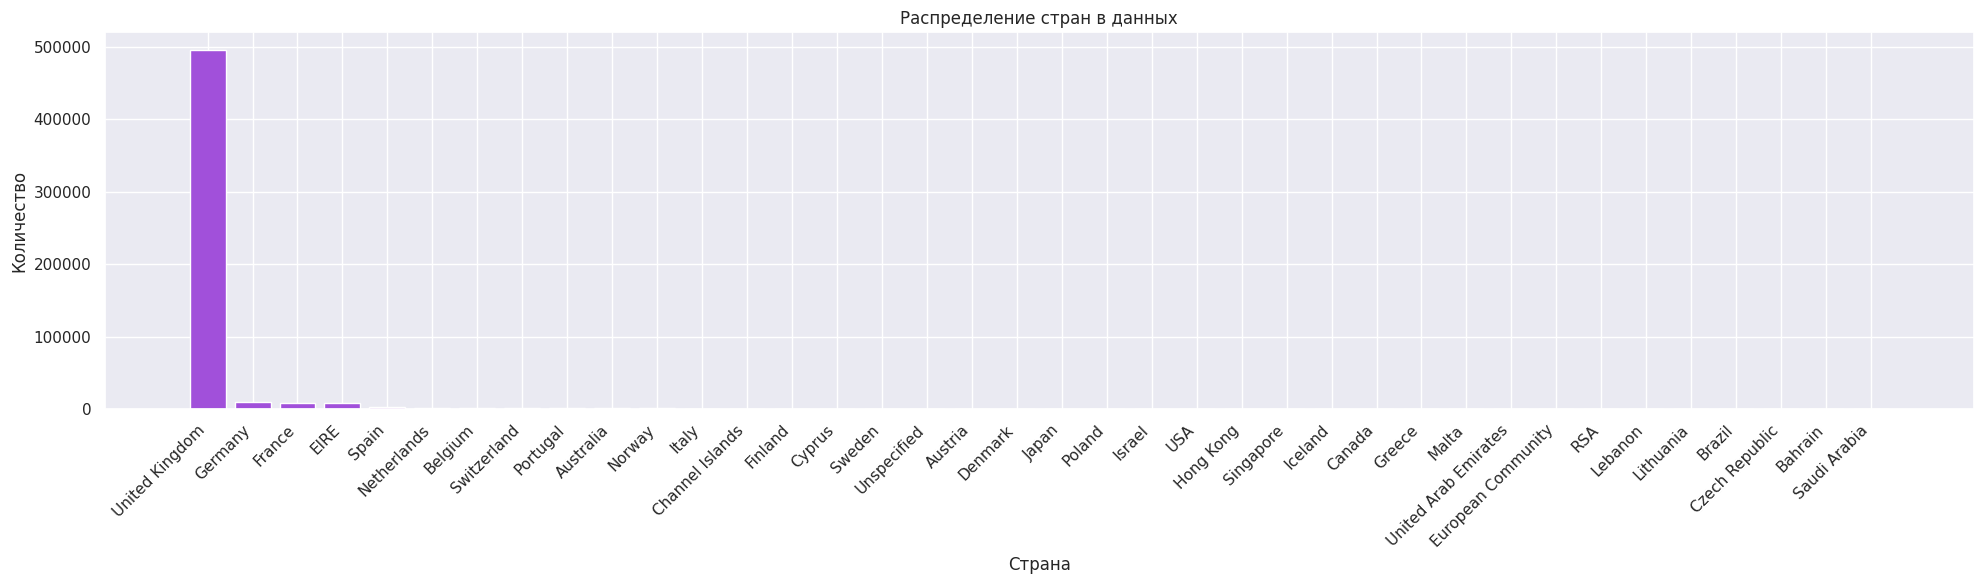

В данных 37 уникальных стран


In [12]:
country_counts = data.groupby('Country')['Country'].count().reset_index(name='count').sort_values(by='count', ascending=False)

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(country_counts['Country'], country_counts['count'])
plt.xlabel('Страна')
plt.ylabel('Количество')
plt.title('Распределение стран в данных')
plt.xticks(rotation=45, ha='right')  # Поворот меток и выравнивание по правому краю
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()
print(f"В данных {data['Country'].nunique() - 1} уникальных стран")

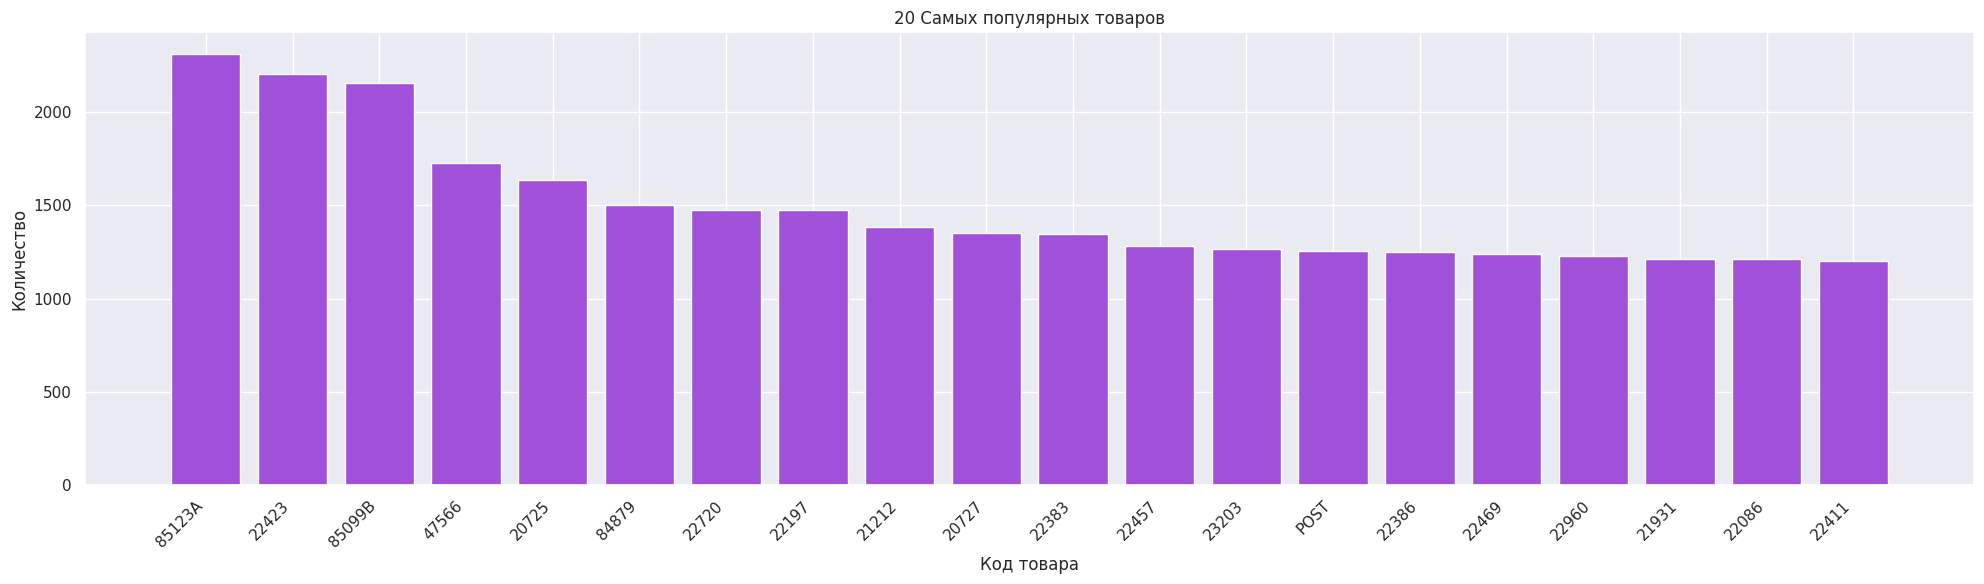

In [13]:
stock_counts = data.groupby('StockCode')['StockCode'].count().reset_index(name='count').sort_values(by='count', ascending=False)[:20]

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(stock_counts['StockCode'], stock_counts['count'])
plt.xlabel('Код товара')
plt.ylabel('Количество')
plt.title('20 Самых популярных товаров')
plt.xticks(rotation=45, ha='right')  # Поворот меток и выравнивание по правому краю
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()

## Предобработка и очистка данных

In [14]:
data = data.dropna()

In [15]:
print("Количество дубликатов:", data.duplicated().sum())

# Удаление дубликатов
data = data.drop_duplicates()

# Проверка результата
print("DataFrame после удаления дубликатов:")
print(data.shape)

Количество дубликатов: 5225
DataFrame после удаления дубликатов:
(401604, 8)


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [16]:
negative_quantity = data[(data['Quantity']<0)]
print('Количество товара с отрицательным значением: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество товара с отрицательным значением: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [17]:
negative_quantity['blowout'] = negative_quantity.apply(lambda x: 1 if not x['InvoiceNo'].startswith('C') else 0, axis=1)
negative_quantity['blowout'].sum()

0

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [18]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.


In [19]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)

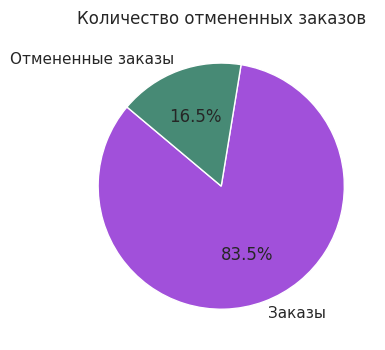

In [20]:
fig, axes = plt.subplots(figsize=(4, 4))
df_counts = nb_products_per_basket['order_canceled'].value_counts()

plt.pie(
    df_counts,
    labels = ['Заказы', 'Отмененные заказы'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['#a150da', '#478a75']
);

plt.title("Количество отмененных заказов")
plt.tight_layout()

Не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

In [21]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Для первой строки, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нету. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе.

Рассмотрим такой пример, относящийся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [22]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.

Не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Реализуем функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [23]:
def get_quantity_canceled(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0):
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  


In [24]:
data = data[data['Quantity'] >= 0]
data.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций.


Специальные операции не характеризуют наших клиентов, поэтому такие записи не нужны. Удалим их


In [25]:
data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [26]:
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+')]
data.shape

(391183, 9)

In [27]:
print(f"В {round(data[data['UnitPrice'] == 0].shape[0] / data.shape[0] * 100, 2)}% транзакций цена товара равна 0")

В 0.01% транзакций цена товара равна 0


In [28]:
data = data[data['UnitPrice'] > 0]
data.shape

(391150, 9)

In [29]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [30]:
data.to_csv('data_new.csv', index=False)

##  Разведывательный анализ данных

Решим следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты.
Оценим именно уникальных клиентов.


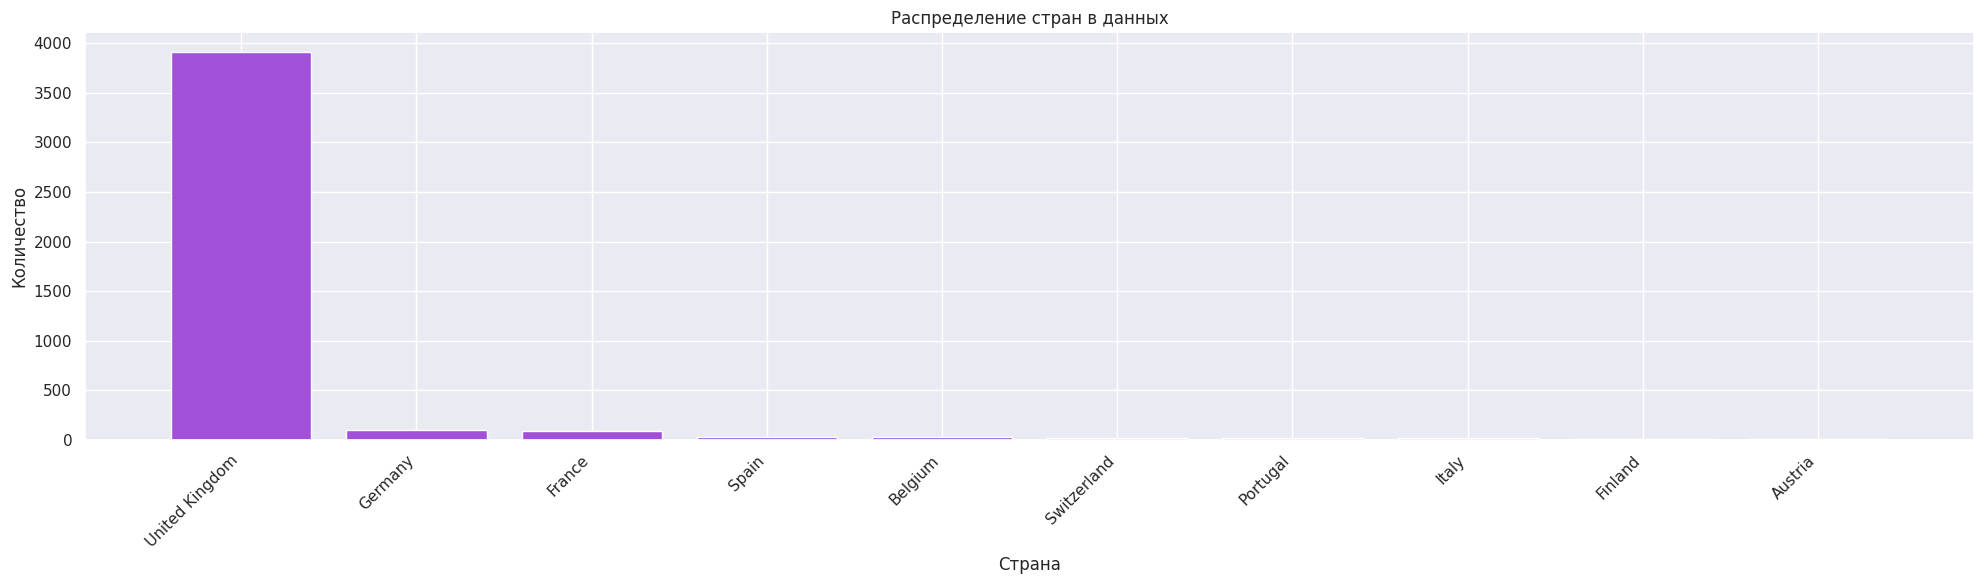

In [31]:
country_counts = data.groupby('Country')['CustomerID'].nunique().reset_index(name='count').sort_values(by='count', ascending=False)[:10]

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(country_counts['Country'], country_counts['count'])
plt.xlabel('Страна')
plt.ylabel('Количество')
plt.title('Распределение стран в данных')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Практически все клиенты в данных из Великобритании.

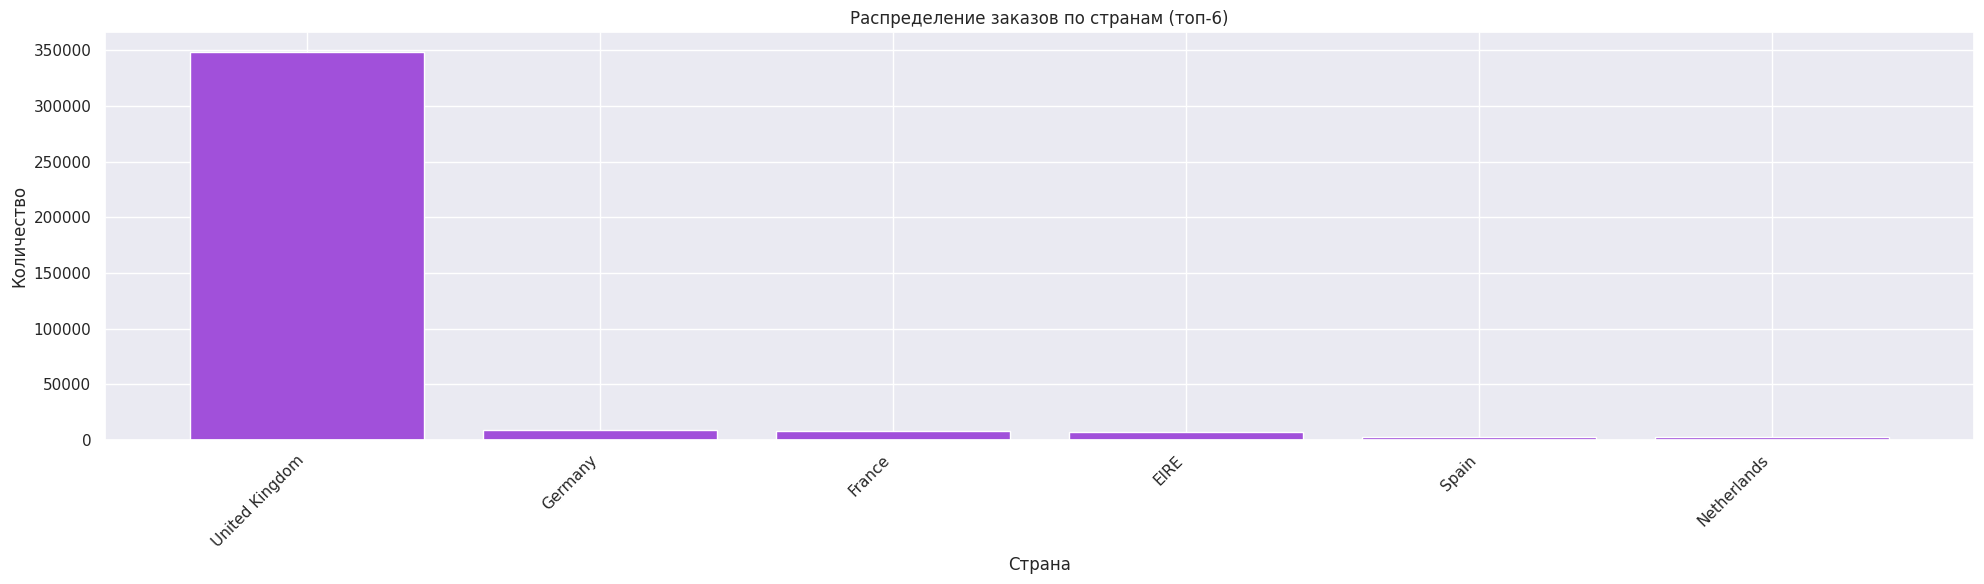

In [32]:
country_counts = data.groupby('Country')['StockCode'].count().reset_index(name='count').sort_values(by='count', ascending=False)[:6]

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(country_counts['Country'], country_counts['count'])
plt.xlabel('Страна')
plt.ylabel('Количество')
plt.title('Распределение заказов по странам (топ-6)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Топ-3 страны по количеству поступающих заказов:

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)


Добавим в датасет общую цену заказа, TotalPrice.
Общая цена заказа рассчитывается как:


In [33]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

print(f"Средняя общая стоимость заказов  = {data['TotalPrice'].mean().round()} фунт(ов) стерлингов")


Средняя общая стоимость заказов  = 21.0 фунт(ов) стерлингов


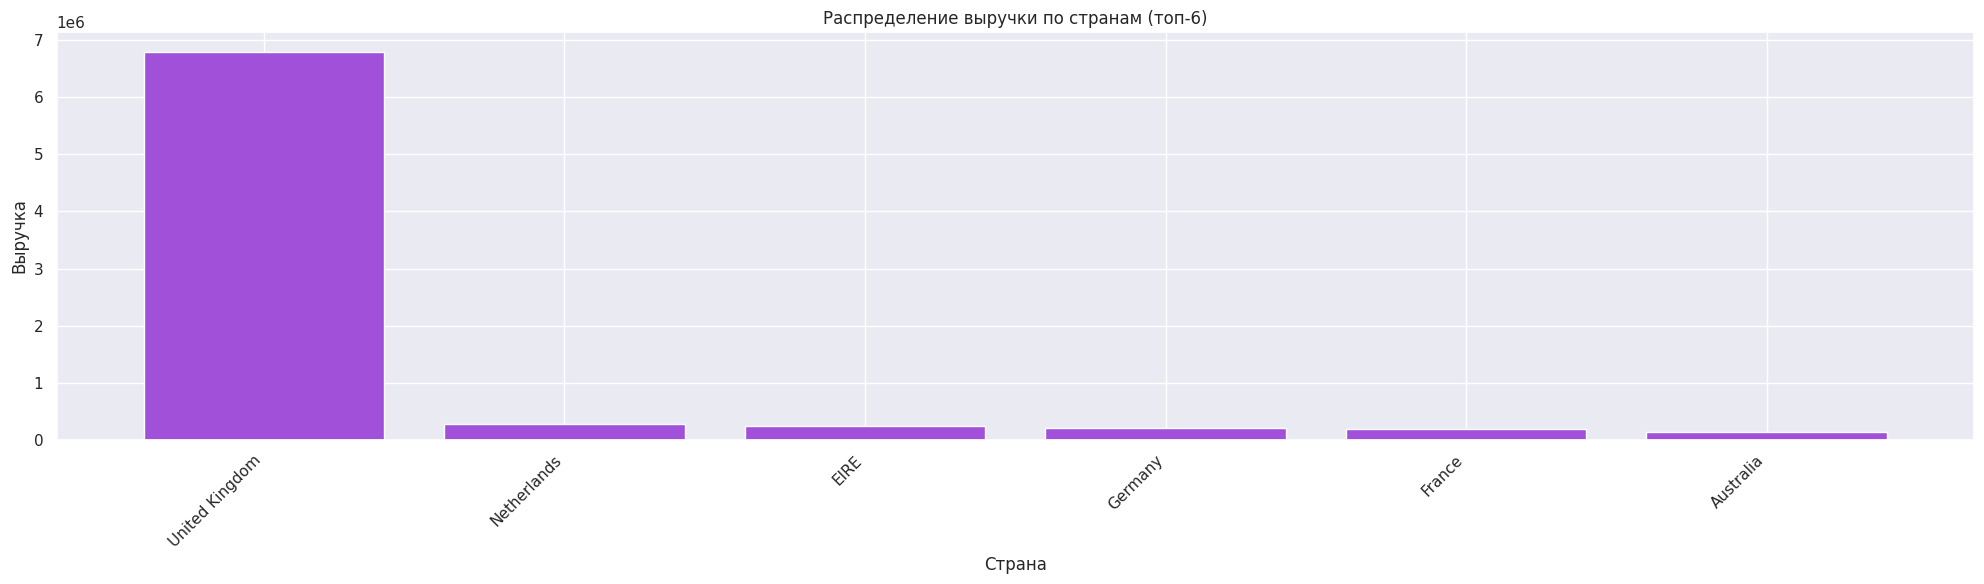

In [34]:
country_revenue = data.groupby('Country')['TotalPrice'].sum().reset_index(name='sum').sort_values(by='sum', ascending=False)[:6]

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(country_revenue['Country'], country_revenue['sum'])
plt.xlabel('Страна')
plt.ylabel('Выручка')
plt.title('Распределение выручки по странам (топ-6)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Теперь займёмся временными характеристиками.


In [35]:
data['Month'] = data['InvoiceDate'].dt.month
data['WeekDay'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour

In [36]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

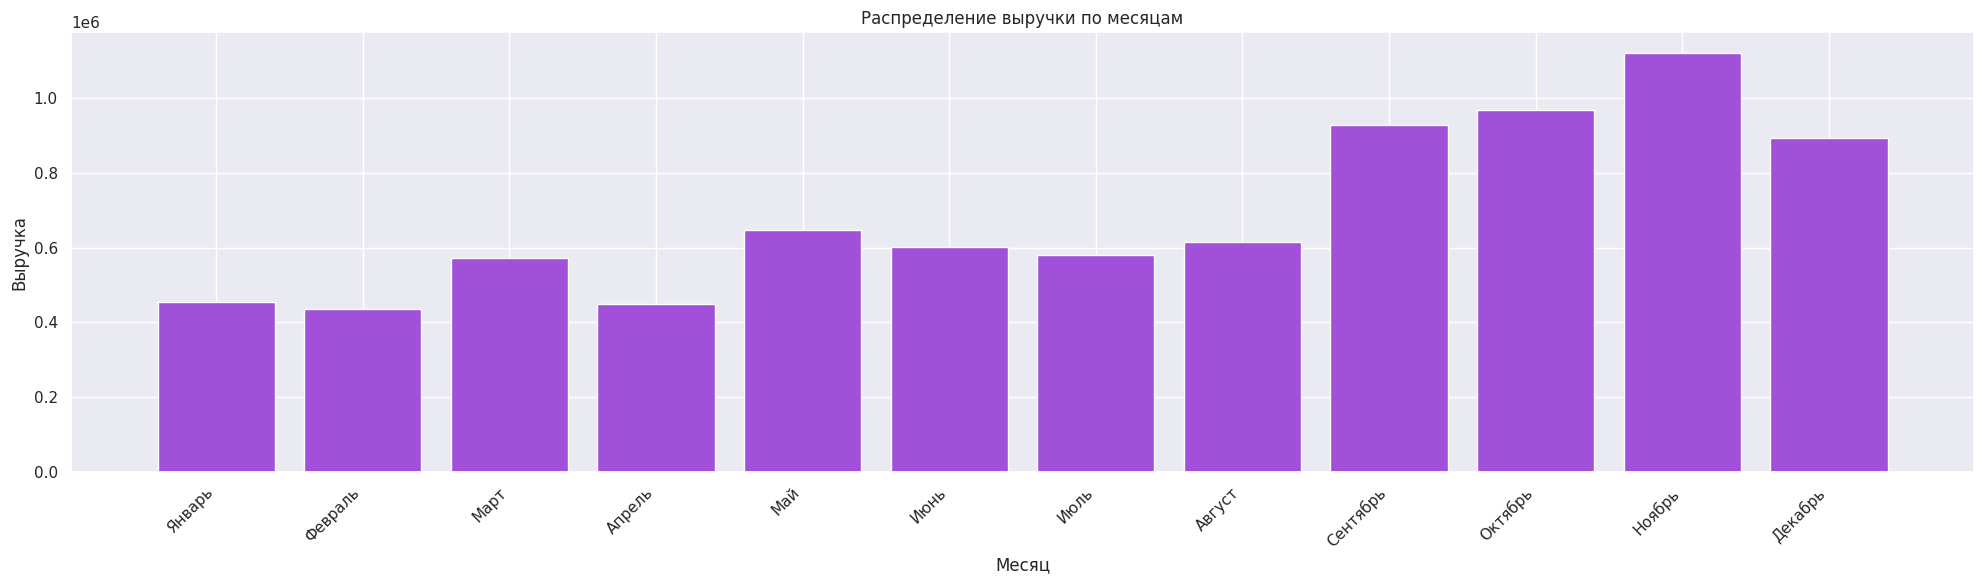

In [37]:
month_revenue = data.groupby('Month')['TotalPrice'].sum().reset_index(name='sum').sort_values(by='Month')
months_ru = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь',
    7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
}
month_revenue['Month'] = month_revenue['Month'].map(months_ru)

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(month_revenue['Month'], month_revenue['sum'])
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Распределение выручки по месяцам')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как анализируем данные магазина подарков, то совсем не удивительно, что видим максимальный рост продаж в преддверии этих праздников.

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота
* Воскресенье


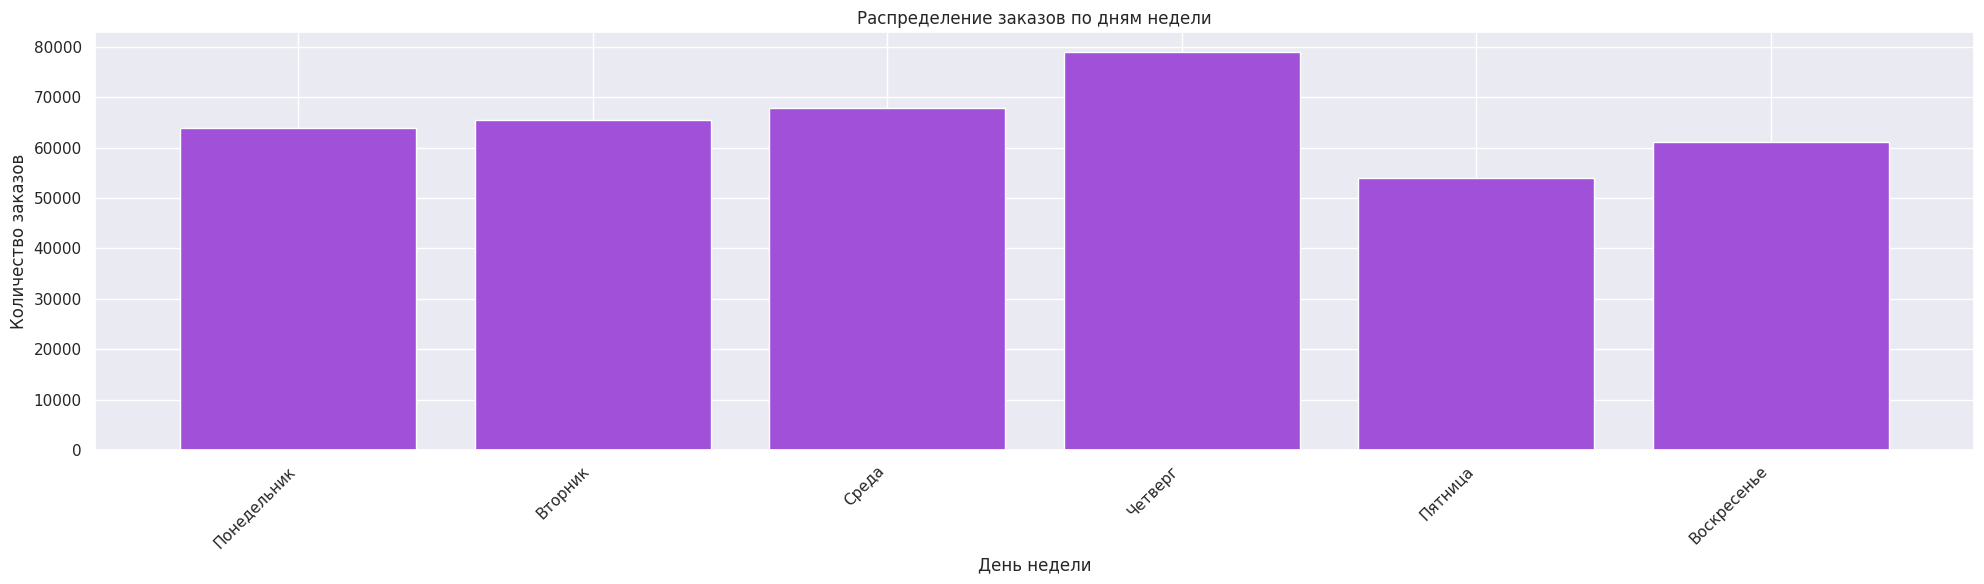

In [38]:
weekday_revenue = data.groupby('WeekDay')['StockCode'].count().reset_index(name='count').sort_values(by='WeekDay')
days_ru = {
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота',
    6: 'Воскресенье'
}
weekday_revenue['WeekDay'] = weekday_revenue['WeekDay'].map(days_ru)

# Построение барплота
plt.figure(figsize=(20, 6))
plt.bar(weekday_revenue['WeekDay'], weekday_revenue['count'])
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по дням недели')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

В субботу не было ни одной транзакции.

In [39]:
data['Date'] = data['InvoiceDate'].dt.date

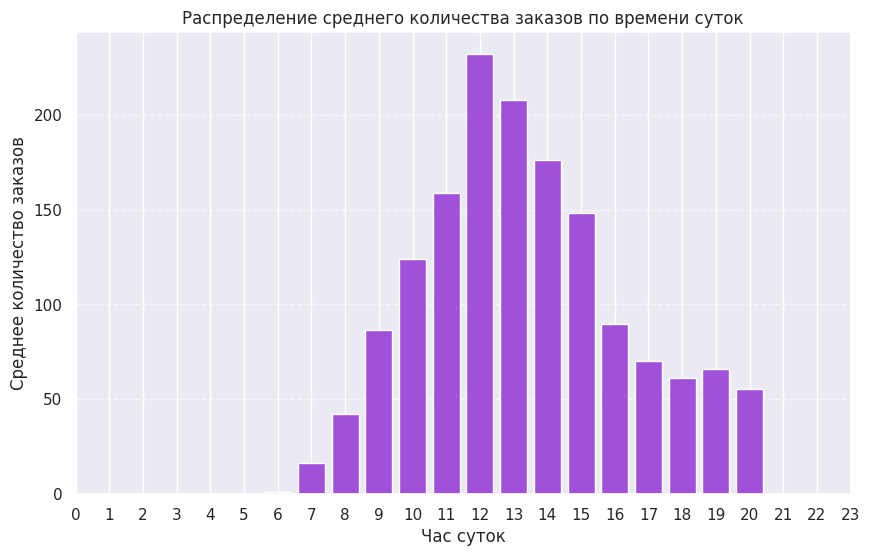

In [40]:
#  Группируем по дате и часу, считаем количество заказов
orders_per_hour = data.groupby(['Date', 'Hour']).size().reset_index(name='Orders')

#  Находим среднее количество заказов по часам
average_orders_per_hour = orders_per_hour.groupby('Hour')['Orders'].mean().reset_index()

#  Визуализация
plt.figure(figsize=(10, 6))
plt.bar(average_orders_per_hour['Hour'], average_orders_per_hour['Orders'])
plt.xlabel('Час суток')
plt.ylabel('Среднее количество заказов')
plt.title('Распределение среднего количества заказов по времени суток')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## RFM-сегментация клиентов: часть 1

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Создадим RFM-таблицу.

Сгруппируем данные по идентификаторам клиента и рассчитаем следующие  агрегированные характеристики:

* Recency для i-го клиента (разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни)
* Frequency (общее количество уникальных заказов, которые совершил i-ый клиент)
* Monetary (общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов))


In [137]:
rfm_table = data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', 'max'),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
    )
rfm_table['Recency'] = (pd.to_datetime('2011-12-10 00:00:00') - rfm_table['Recency']).dt.days

Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [138]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.
Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков.


In [139]:
# Вычисляем 95-й процентиль для Frequency и Monetary
q_f = rfm_table['Frequency'].quantile(0.95)
q_m = rfm_table['Monetary'].quantile(0.95)

# Фильтруем таблицу, оставляя только те записи, которые не превышают указанные квантили
rfm_table = rfm_table[(rfm_table['Frequency'] <= q_f) & (rfm_table['Monetary'] <= q_m)]

In [83]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Построим визуализацию нашего трёхмерного пространства признаков:


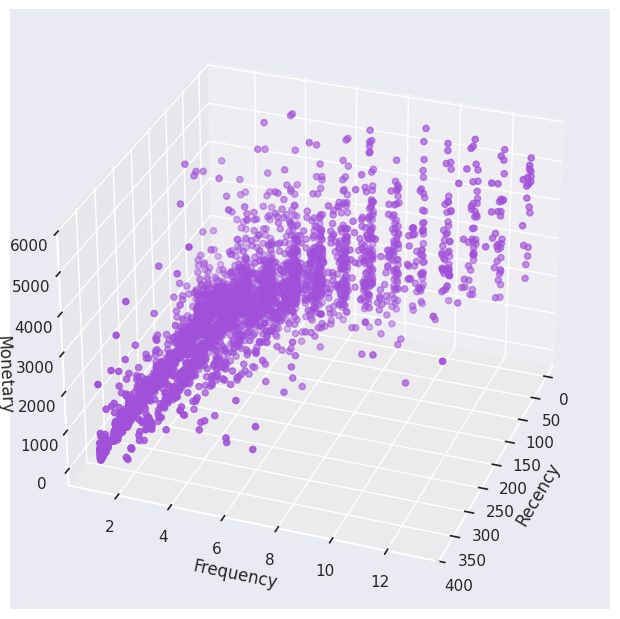

In [85]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table['Recency'].to_list(),
    rfm_table['Frequency'].to_list(),
    rfm_table['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


### Создадим pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* метод главных компонент с двумя компонентами.



In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Обучение пайплайна на данных и применение трансформации
pipeline.fit(rfm_table)
transformed_data = pipeline.transform(rfm_table)

# Получение доли дисперсии, объясняемой первой главной компонентой
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_[0]

# Округление до двух знаков после запятой
explained_variance_rounded = round(explained_variance, 2)

print(f"Доля дисперсии, объясняемая первой главной компонентой: {explained_variance_rounded}")

Доля дисперсии, объясняемая первой главной компонентой: 0.68


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

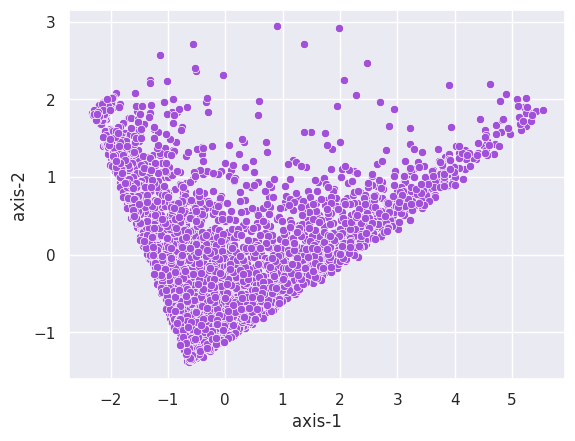

In [90]:
rfm_table_processed = pd.DataFrame(transformed_data, columns=['axis-1', 'axis-2'])
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты.

### Воспользуемся методом k-means.


In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 11)  # от 2 до 10 включительно
silhouette_scores = []

# Подбор количества кластеров
for n_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(rfm_table_processed)

    # Прогнозируем кластеры
    cluster_labels = kmeans.labels_

    # Рассчитываем коэффициент силуэта
    silhouette_avg = silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Количество кластеров: {n_clusters}, коэффициент силуэта: {silhouette_avg:.4f}')

# Определяем лучшее количество кластеров
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

# Результаты
print(f'\nНаилучшее количество кластеров: {best_n_clusters}')
print(f'Максимальное значение коэффициента силуэта: {max_silhouette_score:.2f}')

Количество кластеров: 2, коэффициент силуэта: 0.5002
Количество кластеров: 3, коэффициент силуэта: 0.5241
Количество кластеров: 4, коэффициент силуэта: 0.4976
Количество кластеров: 5, коэффициент силуэта: 0.4491
Количество кластеров: 6, коэффициент силуэта: 0.4480
Количество кластеров: 7, коэффициент силуэта: 0.4455
Количество кластеров: 8, коэффициент силуэта: 0.4244
Количество кластеров: 9, коэффициент силуэта: 0.4223
Количество кластеров: 10, коэффициент силуэта: 0.4130

Наилучшее количество кластеров: 3
Максимальное значение коэффициента силуэта: 0.52


### Возьмём EM-алгоритм.



In [92]:
from sklearn.mixture import GaussianMixture

range_n_clusters = range(2, 11)  # от 2 до 10 включительно
silhouette_scores = []

# Подбор количества кластеров
for n_clusters in range_n_clusters:

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(rfm_table_processed)

    # Прогнозируем кластеры
    cluster_labels = gmm.predict(rfm_table_processed)

    # Рассчитываем коэффициент силуэта
    silhouette_avg = silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Количество кластеров: {n_clusters}, коэффициент силуэта: {silhouette_avg:.4f}')

# Определяем лучшее количество кластеров
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

# Результаты
print(f'\nНаилучшее количество кластеров: {best_n_clusters}')
print(f'Максимальное значение коэффициента силуэта: {max_silhouette_score:.2f}')

Количество кластеров: 2, коэффициент силуэта: 0.3425
Количество кластеров: 3, коэффициент силуэта: 0.4358
Количество кластеров: 4, коэффициент силуэта: 0.3501
Количество кластеров: 5, коэффициент силуэта: 0.2797
Количество кластеров: 6, коэффициент силуэта: 0.2726
Количество кластеров: 7, коэффициент силуэта: 0.2366
Количество кластеров: 8, коэффициент силуэта: 0.1952
Количество кластеров: 9, коэффициент силуэта: 0.1624
Количество кластеров: 10, коэффициент силуэта: 0.1452

Наилучшее количество кластеров: 3
Максимальное значение коэффициента силуэта: 0.44


In [93]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_table_processed)
labels = kmeans.labels_

In [97]:
unique_values, counts = np.unique(labels, return_counts=True)

# Создаем словарь для удобства
value_counts = dict(zip(unique_values, counts))
print(value_counts)

{0: 773, 1: 1001, 2: 2270}


Визуализируем результаты кластеризации:

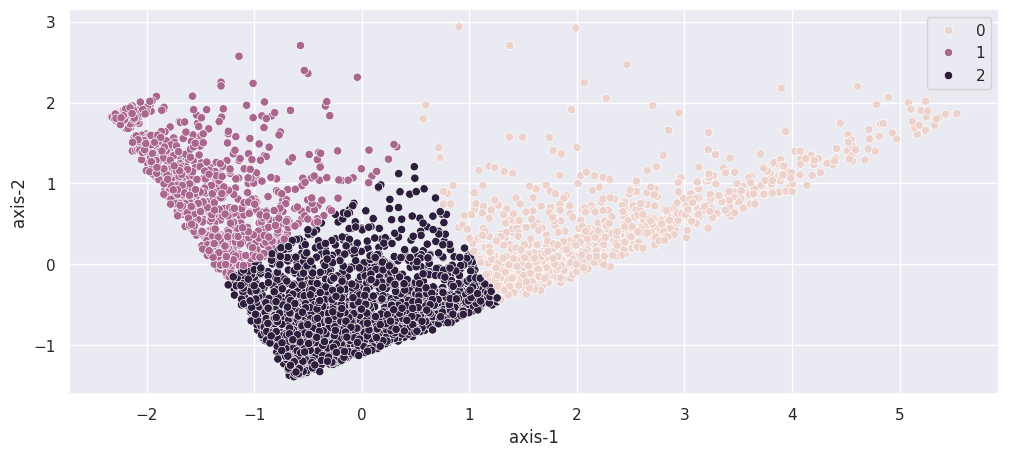

In [94]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed,
    x='axis-1',
    y='axis-2',
    hue=labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

In [98]:
rfm_table['Cluster'] = labels

In [104]:
rfm_m = rfm_table.groupby('Cluster').mean().round()
rfm_m

,Recency,Frequency,Monetary
Cluster,,,
0,32.0,7.0,2662.0
1,253.0,1.0,387.0
2,51.0,2.0,661.0


### Полярная диаграмма
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>



In [106]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()


In [108]:
plot_cluster_profile(rfm_m, 3)

* Кластер 0 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 1 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


###  RFM-сегментация клиентов: часть 2

### Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление.

Для удобства обернём шаги по предобработке данных в pipeline.

* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.




In [109]:
rfm_table

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,0.00,1
12347,2,7,4310.00,0
12348,75,4,1437.24,2
12349,18,1,1457.55,2
12350,310,1,294.40,1
...,...,...,...,...
18278,73,1,173.90,2
18280,277,1,180.60,1
18281,180,1,80.82,1


In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import numpy as np

# Убедимся, что в таблице только признаки Recency, Frequency и Monetary
rfm_data = rfm_table[['Recency', 'Frequency', 'Monetary']]

# Создаём Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('tsne', TSNE(n_components=2, perplexity=50, random_state=100))  # t-SNE
])

# Обучаем pipeline и применяем трансформацию
transformed_data = pipeline.fit_transform(rfm_data)

# Получаем значение дивергенции Кульбака — Лейблера
kl_divergence = pipeline.named_steps['tsne'].kl_divergence_

# Округляем до двух знаков после точки
kl_divergence_rounded = round(kl_divergence, 2)

print("Дивергенция Кульбака — Лейблера:", kl_divergence_rounded)

Дивергенция Кульбака — Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


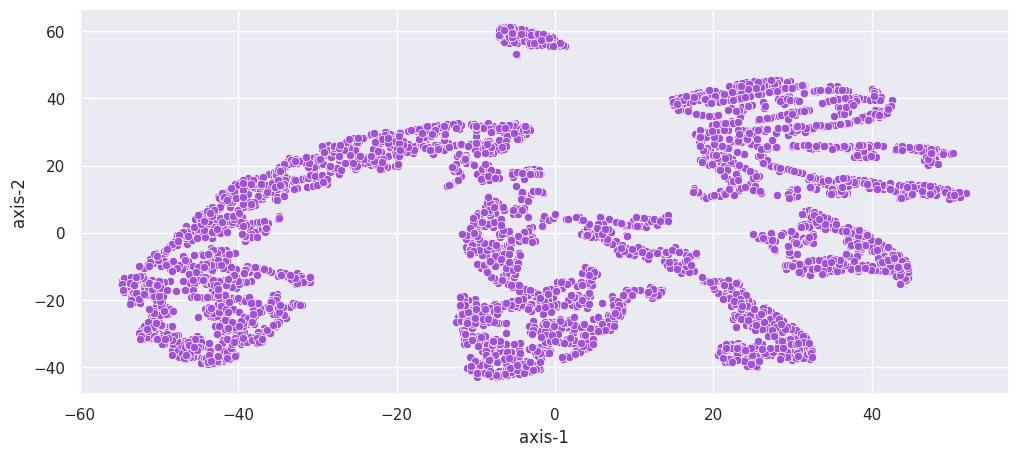

In [112]:
rfm_table_processed = pd.DataFrame(transformed_data, columns=['axis-1', 'axis-2'])
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

t-SNE сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.



### k-means



In [113]:
range_n_clusters = range(3, 9)
silhouette_scores = []

# Подбор количества кластеров
for n_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(transformed_data)

    # Прогнозируем кластеры
    cluster_labels = kmeans.labels_

    # Рассчитываем коэффициент силуэта
    silhouette_avg = silhouette_score(transformed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Количество кластеров: {n_clusters}, коэффициент силуэта: {silhouette_avg:.4f}')

# Определяем лучшее количество кластеров
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

# Результаты
print(f'\nНаилучшее количество кластеров: {best_n_clusters}')
print(f'Максимальное значение коэффициента силуэта: {max_silhouette_score:.2f}')

Количество кластеров: 3, коэффициент силуэта: 0.4288
Количество кластеров: 4, коэффициент силуэта: 0.4792
Количество кластеров: 5, коэффициент силуэта: 0.4779
Количество кластеров: 6, коэффициент силуэта: 0.4602
Количество кластеров: 7, коэффициент силуэта: 0.4769
Количество кластеров: 8, коэффициент силуэта: 0.4816

Наилучшее количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.48


###  EM-алгоритм

In [114]:
range_n_clusters = range(3, 8)  # от 2 до 10 включительно
silhouette_scores = []

# Подбор количества кластеров
for n_clusters in range_n_clusters:

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(transformed_data)

    # Прогнозируем кластеры
    cluster_labels = gmm.predict(transformed_data)

    # Рассчитываем коэффициент силуэта
    silhouette_avg = silhouette_score(transformed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Количество кластеров: {n_clusters}, коэффициент силуэта: {silhouette_avg:.4f}')

# Определяем лучшее количество кластеров
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

# Результаты
print(f'\nНаилучшее количество кластеров: {best_n_clusters}')
print(f'Максимальное значение коэффициента силуэта: {max_silhouette_score:.2f}')

Количество кластеров: 3, коэффициент силуэта: 0.4269
Количество кластеров: 4, коэффициент силуэта: 0.4688
Количество кластеров: 5, коэффициент силуэта: 0.3903
Количество кластеров: 6, коэффициент силуэта: 0.3851
Количество кластеров: 7, коэффициент силуэта: 0.4486

Наилучшее количество кластеров: 4
Максимальное значение коэффициента силуэта: 0.47


### AgglomerativeClustering

Коэффициенты силуэта для каждого количества кластеров:
2 кластеров: 0.380
3 кластеров: 0.423
4 кластеров: 0.457
5 кластеров: 0.470
6 кластеров: 0.469
7 кластеров: 0.459
8 кластеров: 0.479

Наилучшее количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.48


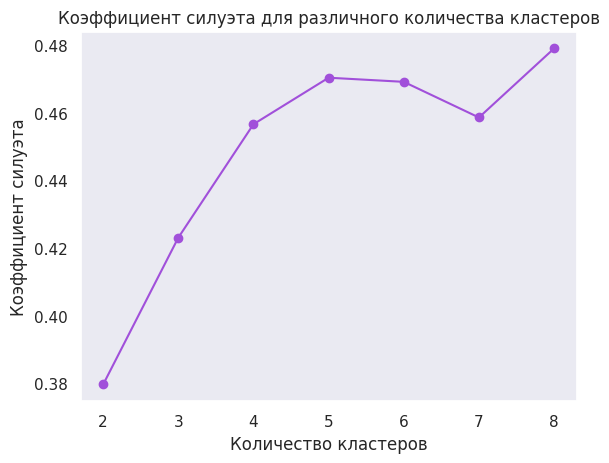

In [116]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

range_values = range(2, 9)
# Хранение значений коэффициента силуэта
silhouette_scores = []

for n_clusters in range_values:

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(transformed_data)

    silhouette_avg = silhouette_score(transformed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)


print("Коэффициенты силуэта для каждого количества кластеров:")
for n_clusters, score in zip(range_values, silhouette_scores):
    print(f"{n_clusters} кластеров: {score:.3f}")

# Находим максимальное значение коэффициента силуэта
best_score = max(silhouette_scores)
best_num_clusters = range_values[silhouette_scores.index(best_score)]

print(f"\nНаилучшее количество кластеров: {best_num_clusters}")
print(f"Максимальное значение коэффициента силуэта: {best_score:.2f}")

# Визуализируем результаты
plt.plot(range_values, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта для различного количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range_values)
plt.grid()
plt.show()

In [131]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(transformed_data)

    # Прогнозируем кластеры
cluster_labels = kmeans.labels_

In [132]:
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Создаем словарь для удобства
value_counts = dict(zip(unique_values, counts))
print(value_counts)

{0: 912, 1: 604, 2: 728, 3: 658, 4: 606, 5: 422, 6: 114}


Визуализируем результаты кластеризации:

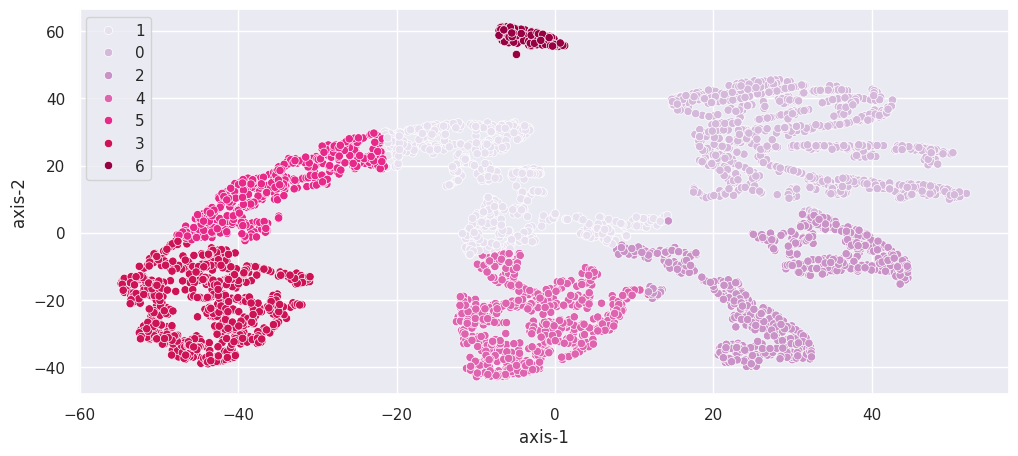

In [133]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', palette='PuRd', hue=cluster_labels.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов.


In [134]:
rfm_data['Cluster'] = cluster_labels
rfm_m = rfm_data.groupby('Cluster').mean().round()

rfm_m

,Recency,Frequency,Monetary
Cluster,,,
0,32.0,7.0,2417.0
1,251.0,2.0,491.0
2,45.0,3.0,981.0
3,46.0,1.0,321.0
4,50.0,2.0,629.0
5,185.0,1.0,263.0
6,365.0,1.0,236.0


In [144]:
plot_cluster_profile(rfm_m, 7)

## RFM-кластеризация клиентов: часть 3

 Проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.
 У класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.
Сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент.

In [141]:
from sklearn.model_selection import train_test_split

X = rfm_table
y = cluster_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape


(809, 3)

### RandomForestClassifier


In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Сетка параметров
param_grid = {
    'max_depth': range(5, 15),  # Максимальная глубина деревьев
    'criterion': ['gini', 'entropy'],  # Критерий разделения
    'n_estimators': [100, 200, 500]  # Количество деревьев
}

# Создаём модель случайного леса
rf = RandomForestClassifier(random_state=42)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',  # Метрика accuracy
    cv=5,  # Количество фолдов для кросс-валидации
    n_jobs=-1  # Использование всех ядер процессора
)

# Обучаем GridSearchCV на тренировочной выборке
grid_search.fit(X_train, y_train)

# 1) Оптимальная максимальная глубина деревьев
best_max_depth = grid_search.best_params_['max_depth']
print("Оптимальная максимальная глубина деревьев:", best_max_depth)

# 2) Предсказание и оценка accuracy на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", round(accuracy, 3))


Оптимальная максимальная глубина деревьев: 13
Accuracy на тестовой выборке: 0.985


Итак, значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

### GradientBoostingClassifier


In [143]:
from sklearn.ensemble import GradientBoostingClassifier

# Сетка параметров
param_grid = {
    'max_depth': range(3, 7),  # Максимальная глубина деревьев
    'learning_rate': [0.001, 0.01, 0.1],  # Скорость обучения
    'n_estimators': [100, 200, 500]  # Количество деревьев
}

# Создаём модель градиентного бустинга
gb = GradientBoostingClassifier(random_state=42)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='accuracy',  # Метрика accuracy
    cv=5,  # Количество фолдов для кросс-валидации
    n_jobs=-1  # Использование всех ядер процессора
)

# Обучаем GridSearchCV на тренировочной выборке
grid_search.fit(X_train, y_train)

# 1) Оптимальная максимальная глубина деревьев
best_max_depth = grid_search.best_params_['max_depth']
print("Оптимальная максимальная глубина деревьев:", best_max_depth)

# 2) Предсказание и оценка accuracy на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", round(accuracy, 3))

Оптимальная максимальная глубина деревьев: 4
Accuracy на тестовой выборке: 0.985
